In [1]:

from parse_data import get_data
from gan import Generator

df = get_data()

In [2]:
df["creation_time"][0] - df["creation_time"][1]

-427061

In [3]:
average_diff = 0

c_time = df["creation_time"]

for i in range(1, len(c_time)):
    average_diff += c_time[i] - c_time[i-1]
average_diff/(len(c_time)-1)

1582.8439455281562

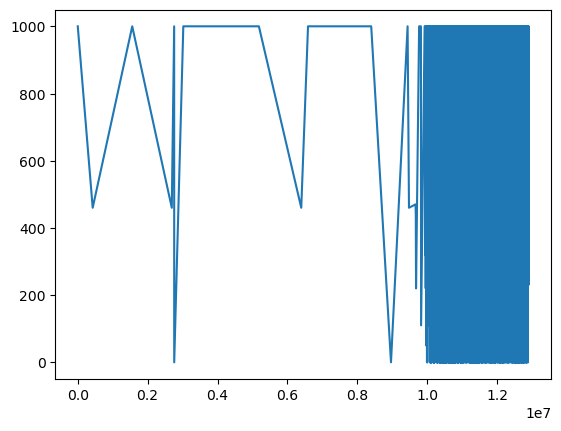

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


ax.plot(df["creation_time"], df["gpu_milli"])

In [5]:
import torch.nn as nn


class PredictTime(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_size = 100
        self.hidden_layers = 10
        self.lstm = nn.LSTM(input_size=2, hidden_size=self.hidden_size, num_layers=self.hidden_layers).double()
        self.linear = nn.Linear(self.hidden_size,1).double()
        self.h_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.c_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.hidden = (self.h_0, self.c_0)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x, self.hidden = self.lstm(x,self.hidden)
        x = self.linear(x)
        return self.sig(x)
    
    def init_state(self):
        self.h_0 = self.hidden[0].detach()
        self.c_0 = self.hidden[1].detach()
        self.hidden = (self.h_0, self.c_0)
    
    def clean_state(self):
        self.h_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.c_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.hidden = (self.h_0, self.c_0)
       

In [6]:
import torch

def make_data(df):
    
    x_train, y_train = [], []
    prev = -1
    count = 1
    m = df.max()[0]
    maxtime = df.max()[1]
    print("Max value: ", m)
    
    for row in df.values:
        x_train.append([prev/m, count/maxtime])
        y_train.append([row[0]/m])
        prev = row[0]
        count += 1
    return torch.tensor(x_train, dtype=torch.double),torch.tensor(y_train, dtype=torch.double)

make_data(df)
        

Max value:  1000


(tensor([[-1.0000e-03,  7.7509e-08],
         [ 1.0000e+00,  1.5502e-07],
         [ 4.6000e-01,  2.3253e-07],
         ...,
         [ 1.0000e+00,  6.3170e-04],
         [ 4.6000e-01,  6.3177e-04],
         [ 5.9000e-01,  6.3185e-04]], dtype=torch.float64),
 tensor([[1.0000],
         [0.4600],
         [1.0000],
         ...,
         [0.4600],
         [0.5900],
         [0.5900]], dtype=torch.float64))

In [ ]:
import warnings
warnings.filterwarnings('error')



import numpy as np
import torch.optim as optim
import torch.utils.data as data
from IPython.display import clear_output

model = Generator()
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()
batch_size = 50
x_d, y_d = make_data(get_data())
loader = data.DataLoader(data.TensorDataset(x_d,y_d), batch_size=batch_size)
epochs = 1000
for e in range(epochs):
    model.train()
    #print(next(iter(loader)))
    model.lstm_zero()
    for x, y in loader:

        #print("XXXX", x, "YYYY", y)
       
        model.init_state()
        pred_total = []
        y_pred = model(x)
        
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
    if e % 10 != 0:
        continue
    #clear_output(wait=True)
    sum_loss = 0

    for x, y in loader:
        model.eval()
        with torch.no_grad():
            y_pred = model(x)
            sum_loss += np.sqrt(loss(y_pred, y))
    
    print("Epoch %d Loss %.4f" % (e, sum_loss))
    
    
#for d in df.values:


Max value:  1000
Epoch 0 Loss 60.0826


In [ ]:
import matplotlib.pyplot as plt

def eval_model(x,y,m):
    df = get_data() 
    maxtime = df.max()[1]

    res = []
    m.eval()
    m.clean_state()
    count  = 1
    val = x[0][0]
    for _ in x:
        t = torch.tensor([[val, count/maxtime]])
        val = m(t)
        count += 1
        res.append(val.detach().numpy()[0])
    
    fig, ax = plt.subplots()
    
    ax.plot(res[900:999])
    ax.plot(y[900:999])

amount = 1000
eval_model(x_d[:amount],y_d[:amount],model)


In [ ]:
import matplotlib.pyplot as plt

def eval_model(x,y,m):
    df = get_data() 
    maxtime = df.max()[1]

    res = []
    m.eval()
    m.clean_state()
    count  = 1
    val = x[0][0]
    for _ in x:
        t = torch.tensor([[val, count/maxtime]])
        val = m(t)
        count += 1
        res.append(val.detach().numpy()[0])
    
    loss = nn.MSELoss()
    print(np.sqrt(loss(torch.tensor(res),y)))
    
    fig, ax = plt.subplots()
    
    ax.plot(res[-50:])
    ax.plot(y[-50:])

amount = 1000
eval_model(x_d,y_d,model)
